#A simple autoencoder test
Bottleneck consists of a single number, which determines the fraction of the image covered in black squares

In [243]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from matplotlib import pyplot as plt

In [143]:
# Decoder goes here
N_image = 28 # Size of (square) input image

def regions(x):
    # x represents the fraction of the image full of ones
    img = np.zeros(N_image*N_image).reshape(N_image,N_image) - 1
    Q = int(np.floor(x*N_image))
    img[:,0:Q] = 1
    return img

[ 1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


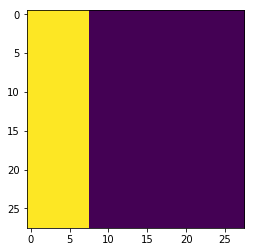

In [144]:
# And here's a test to see that the decoder does what we expect:
plt.imshow(regions(0.3))
print regions(0.3)[int(N_image/2),:]

In [369]:
#Making dataset
N_train = 1000
noise = 0.3

train_images = []
train_labels = []
for i in range(N_train):
    x = np.random.uniform()
    train_labels.append(np.int(np.round(x,1)*10))
    img = regions(x) + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image)
    train_images.append(img)

train_images = np.array(train_images)
train_images_transposed = np.array([img.transpose() for img in train_images])
train_images = np.concatenate((train_images, train_images_transposed))
train_images = train_images.reshape(2*N_train,N_image,N_image,1)
train_labels = np.array(train_labels)

In [370]:
print train_images.shape

(2000, 28, 28, 1)


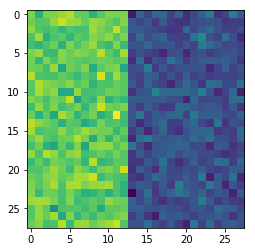

[ 0.77633928  0.74184599  0.91053114  1.02819374  1.19723194  1.29918945
  0.97380538  0.89009095  1.31965468 -1.17309843 -0.99541003 -1.37670462
 -1.42073861 -0.85120618 -0.77210982 -1.20943599 -1.28367486 -1.25158614
 -0.82238067 -1.42533891 -0.89180195 -1.00864249 -0.86482012 -1.20694353
 -0.59576728 -0.86027709 -1.32376012 -1.1597587 ]


In [372]:
# And here's a test to check that the training images are reasonable:
plt.imshow(train_images[7,:,:,0])
plt.show()
print train_images[3,int(N_image/2),:,0]

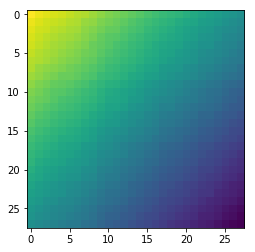

[ 0.4196417   0.36745329  0.34495527  0.30926312  0.27923288  0.24961944
  0.22226502  0.17734917  0.13923592  0.08893427  0.04873177  0.03207957
 -0.01450044 -0.04912959 -0.0851174  -0.12690735 -0.15923734 -0.2216594
 -0.2365973  -0.26769158 -0.30605794 -0.34083771 -0.37954426 -0.40700074
 -0.44410396 -0.47821758 -0.5284403  -0.54516449]


In [373]:
mean_image = np.mean(train_images,axis=0)[:,:,0]
plt.imshow(mean_image)
plt.show()
print mean_image[int(N_image/2),:]

In [374]:
from __future__ import division

def normalize_meanstd(a, axis=None):
    # axis param denotes axes along which mean & std reductions are to be performed
    mean = np.mean(a, axis=axis, keepdims=True)
    std = np.sqrt(((a - mean)**2).mean(axis=axis, keepdims=True))
    return (a - mean) / std, mean, std

train_images_std, mean, std = normalize_meanstd(train_images, axis=(1,2))

In [375]:
#Lambda Layer (Decoder)
def make_regions(x):
    img = tf.to_float(tf.convert_to_tensor(np.repeat(np.arange(N_image),N_image).reshape(N_image,N_image)))
    #np.zeros(N_image*N_image).reshape(N_image,N_image)
    #Q = tf.math.int(tf.math.floor(x*N_image))#int(np.floor(x*N_image))
    #condi = tf.math.greater(img, x)
    unity = tf.convert_to_tensor(np.repeat(1., N_image*N_image).reshape(N_image, N_image))
    zeros = tf.convert_to_tensor(np.zeros(N_image*N_image).reshape(N_image, N_image))
    tf.where(img > x, unity, zeros)
    return img

In [448]:
model = models.Sequential()
filt_size = 3
fs = filt_size
model.add(layers.Conv2D(32, (fs, fs), activation='relu', padding="same", input_shape = (N_image,N_image,1),strides=(1,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3136, activation='relu'))
model.add(layers.Reshape((7, 7, 64)))

model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(1, (fs, fs), activation='sigmoid', padding="same"))

#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(1))
#model.add(layers.Lambda(make_regions))
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_196 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_198 (Conv2D)          (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_22 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)             

In [449]:
model.compile(optimizer='RMSprop',
              loss='mean_squared_error',
              metrics=['accuracy']
             )
#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])


In [450]:
model.fit(train_images, train_images, epochs=5)
#model.fit(train_images, train_labels/10., epochs=5)

Epoch 1/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.7772 - acc: 0.0000e+00
Epoch 2/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.6629 - acc: 0.0000e+00
Epoch 3/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.6482 - acc: 0.0000e+00 0s - loss: 0.6466 - acc: 0.0000
Epoch 4/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.6433 - acc: 0.0000e+00
Epoch 5/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.6380 - acc: 0.0000e+00


In [451]:
test_img = regions(0.7).reshape(28,28,1)# + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image,1)
#test_img = test_img[:,:,0].transpose().reshape(28,28,1)
out = model.predict(np.array([test_img]))

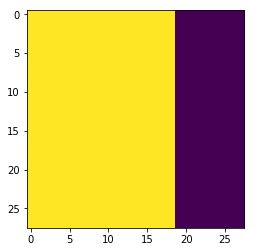

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [452]:
plt.imshow(test_img[:,:,0])
plt.show()
print test_img[0,:,0]

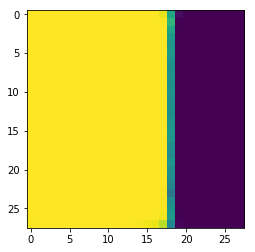

[9.9999988e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 9.9999869e-01 9.9999237e-01 9.9770725e-01 5.3272110e-01 6.0382485e-04
 5.9604645e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]


In [453]:
plt.imshow(out[0,:,:,0])
plt.show()
print out[0,15,:,0]
#print out

In [459]:
w = model.get_weights()
warr = np.array(w)
print warr[6].shape

(3136, 128)


(array([3.0000e+00, 2.0000e+01, 6.1000e+01, 1.9000e+02, 4.7300e+02,
        1.0790e+03, 2.2300e+03, 4.6000e+03, 2.2408e+04, 3.7023e+04,
        3.9466e+04, 4.0817e+04, 4.1782e+04, 4.1852e+04, 4.1380e+04,
        4.0576e+04, 3.8799e+04, 3.2263e+04, 9.0460e+03, 3.7440e+03,
        1.9280e+03, 8.9200e+02, 4.2500e+02, 1.7400e+02, 9.4000e+01,
        4.7000e+01, 2.5000e+01, 6.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([-0.1209149 , -0.11188992, -0.10286494, -0.09383997, -0.08481499,
        -0.07579001, -0.06676503, -0.05774006, -0.04871508, -0.0396901 ,
        -0.03066512, -0.02164015, -0.01261517, -0.00359019,  0.00543479,
         0.01445976,  0.02348474,  0.03250972,  0.0415347 ,  0.05055967,
         0.05958465,  0.06860963,  0.0776346 ,  0.08665958,  0.09568456,
         0.10470954,  0.11373451,  0.12275949,  0.13178447,  0.14080945,
         0.14983442], dtype=float32),
 <a list of 30 Patch objects>)

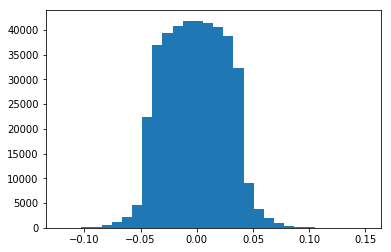

In [467]:
#plt.imshow(warr[6],aspect='auto')
plt.hist(warr[6].reshape(-1),bins=30)

In [456]:
for i in np.arange(64):    
    plt.imshow(w[2][:,:,0,i])
    #plt.imshow(np.random.uniform(-1,1,9*9).reshape(9,9))
    plt.show()

IndexError: too many indices for array

In [191]:
#Lambda Layer (Decoder) (TL's copy):
def make_regions(x):
    x_int = x[1]
    print x, tf.to_float(x_int)
    img = np.zeros(N_image*N_image).reshape(N_image,N_image)
    Q = int(np.floor(x_int*N_image))
    img[:,0:Q] = 1
    return img

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.add(layers.Lambda(make_regions))

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                36928     
__________

In [5]:
# Here's the mnist train data, for reference:

#mnist_data = np.load('mnist.npz')
#(train_images, train_labels), (test_images, test_labels) = (mnist_data['x_train'], mnist_data['y_train']), (mnist_data['x_test'], mnist_data['y_test'])

In [6]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


In [66]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [15]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [18]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                36928     
__________

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
 2400/60000 [>.............................] - ETA: 3:03 - loss: 1.0760 - acc: 0.6562

60000/60000 [==============================] - 134s 2ms/step - loss: 0.0197 - acc: 0.9940


In [23]:
model.predict_classes(np.array([test_images[0]]))

array([7])

In [24]:
test_labels[0]

7

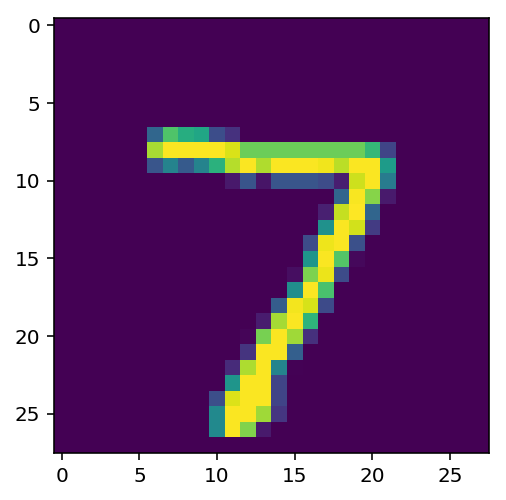

In [28]:
import matplotlib.pyplot as plt
plt.imshow(test_images[0][:,:,0])